/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_99534/664330942.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sin(2 * np.pi * x) + np.sin(20 * np.pi * x)


Starting training...
Epoch 10/10000, Train Loss: 0.8707, Test Loss: 0.8589
Epoch 1000/10000, Train Loss: 0.0000, Test Loss: 0.0000
Epoch 10000/10000, Train Loss: 0.0000, Test Loss: 0.0000
Training finished.
Generating plots...


/var/folders/w8/xz590jyd7r36zmxcspgzj3z40000gn/T/ipykernel_99534/664330942.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.90]) # Adjust layout to make space for titles


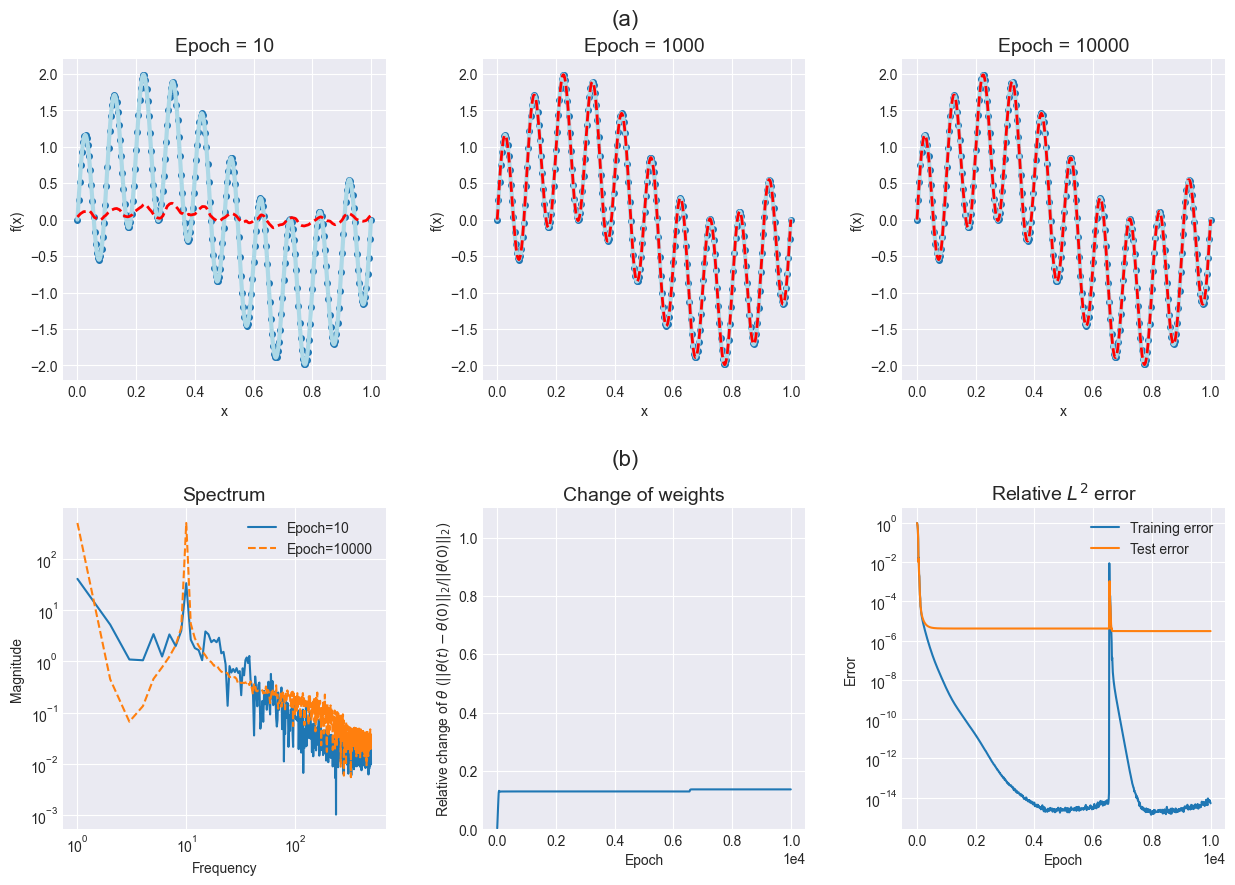

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- 1. Define Target Function and Data ---
def target_function(x):
    """The target function f(x) = sin(2*pi*x) + sin(20*pi*x)"""
    return np.sin(2 * np.pi * x) + np.sin(20 * np.pi * x)

# Generate training and test data
# Using 256 points for training as it's a reasonable number for this function
x_train = torch.linspace(0, 1, 256).view(-1, 1)
y_train = target_function(x_train)

# Using a higher resolution for testing to get smooth curves
x_test = torch.linspace(0, 1, 1000).view(-1, 1)
y_test = target_function(x_test)


# --- 2. Fourier Feature Mapping ---
class FourierFeatureMapping(nn.Module):
    """
    Creates Fourier features by mapping input x to [cos(2*pi*Bx), sin(2*pi*Bx)].
    """
    def __init__(self, input_dim, mapping_size, scale=10.0):
        super().__init__()
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        # Sample B from a Gaussian distribution N(0, scale^2)
        # This parameter is fixed (not trained), so requires_grad=False
        self.B = nn.Parameter(torch.randn((input_dim, mapping_size)) * scale, requires_grad=False)

    def forward(self, x):
        # The mapping formula from the paper
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


# --- 3. Define the Network (MLP) ---
class Net(nn.Module):
    """A simple Multi-Layer Perceptron."""
    def __init__(self, input_features, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

# --- 4. Training Setup ---
# Hyperparameters from the paper/figure caption
epochs = 10000
lr = 1e-4
mapping_size = 256  # As specified in the paper for Fourier features
sigma = 10.0        # Standard deviation for initializing Fourier features

# Initialize the feature mapper and the network
fourier_mapper = FourierFeatureMapping(1, mapping_size, scale=sigma)
network = Net(mapping_size * 2, 256, 1) # Input dimension is doubled due to sin and cos

# Store initial parameters to calculate the relative change later
initial_params = torch.cat([p.detach().clone().flatten() for p in network.parameters()])
initial_norm = torch.linalg.norm(initial_params)

# Standard Adam optimizer and Mean Squared Error loss
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
criterion = nn.MSELoss()

# --- 5. Training Loop ---
# Dictionaries and lists to store history for plotting
history = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'weight_change': [],
    'predictions': {}
}

# Map the input coordinates to Fourier features before the loop
x_train_mapped = fourier_mapper(x_train)
x_test_mapped = fourier_mapper(x_test)

print("Starting training...")
for epoch in range(1, epochs + 1):
    network.train()

    # Forward pass
    predictions = network(x_train_mapped)
    loss = criterion(predictions, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # --- Logging and Storing Data for Plots ---
    if epoch % 10 == 0 or epoch == 1:
        network.eval()
        with torch.no_grad():
            # Calculate test loss for the plot
            test_predictions = network(x_test_mapped)
            test_loss = criterion(test_predictions, y_test)

            # Calculate relative change of the parameters (weights)
            current_params = torch.cat([p.flatten() for p in network.parameters()])
            weight_change = torch.linalg.norm(current_params - initial_params) / initial_norm

            # Append data to history
            history['epoch'].append(epoch)
            history['train_loss'].append(loss.item())
            history['test_loss'].append(test_loss.item())
            history['weight_change'].append(weight_change.item())

            # Store full predictions at specific epochs for the top plots
            if epoch in [10, 1000, 10000]:
                print(f"Epoch {epoch}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")
                history['predictions'][epoch] = network(x_test_mapped).cpu().numpy()

print("Training finished.")

# --- 6. Generate the Figure ---
print("Generating plots...")
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(15, 10))

# Create a 2x3 grid for the subplots
gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3)

# --- Row (a): Network Predictions ---
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
prediction_axes = [ax1, ax2, ax3]
plot_epochs = [10, 1000, 10000]

fig.text(0.5, 0.92, '(a)', ha='center', va='center', fontsize=16)

for i, epoch in enumerate(plot_epochs):
    ax = prediction_axes[i]
    # Plot training data points
    ax.plot(x_train.numpy(), y_train.numpy(), 'o', markersize=4, label='Data points')
    # Plot ground truth function
    ax.plot(x_test.numpy(), y_test.numpy(), color='lightblue', linewidth=3, label='Ground truth')
    # Plot network prediction
    ax.plot(x_test.numpy(), history['predictions'][epoch], 'r--', linewidth=2, label='Network prediction')
    ax.set_title(f'Epoch = {epoch}', fontsize=14)
    ax.set_ylim([-2.2, 2.2])
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')


# --- Row (b): Analysis Plots ---
fig.text(0.5, 0.48, '(b)', ha='center', va='center', fontsize=16)

# (b) left: Spectrum Plot
ax4 = fig.add_subplot(gs[1, 0])
# Calculate FFT for predictions at epoch 10 and 10000
fft_10 = np.fft.fft(history['predictions'][10].flatten())
fft_10000 = np.fft.fft(history['predictions'][10000].flatten())
# Calculate frequencies
freqs = np.fft.fftfreq(len(x_test), d=(x_test[1] - x_test[0]).item())

# Plot only the positive frequency part
positive_freqs_idx = freqs > 0
ax4.loglog(freqs[positive_freqs_idx], np.abs(fft_10)[positive_freqs_idx], label=f'Epoch=10')
ax4.loglog(freqs[positive_freqs_idx], np.abs(fft_10000)[positive_freqs_idx], '--', label=f'Epoch=10000')
ax4.set_title('Spectrum', fontsize=14)
ax4.set_xlabel('Frequency')
ax4.set_ylabel('Magnitude')
ax4.legend()

# (b) middle: Change of Weights Plot
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(history['epoch'], history['weight_change'])
ax5.set_title('Change of weights', fontsize=14)
ax5.set_xlabel('Epoch')
ax5.set_ylabel(r'Relative change of $\theta$ ($||\theta(t) - \theta(0)||_2 / ||\theta(0)||_2$)')
ax5.set_ylim(0, 1.1)
ax5.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


# (b) right: Relative L2 Error Plot
ax6 = fig.add_subplot(gs[1, 2])
ax6.semilogy(history['epoch'], history['train_loss'], label='Training error')
ax6.semilogy(history['epoch'], history['test_loss'], label='Test error')
ax6.set_title('Relative $L^2$ error', fontsize=14)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Error')
ax6.legend()
ax6.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Final figure adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.90]) # Adjust layout to make space for titles
plt.show()

Starting training and NTK calculation...
Logging data at epoch: 10
Logging data at epoch: 100
Logging data at epoch: 1000
Training finished.
Generating plots...


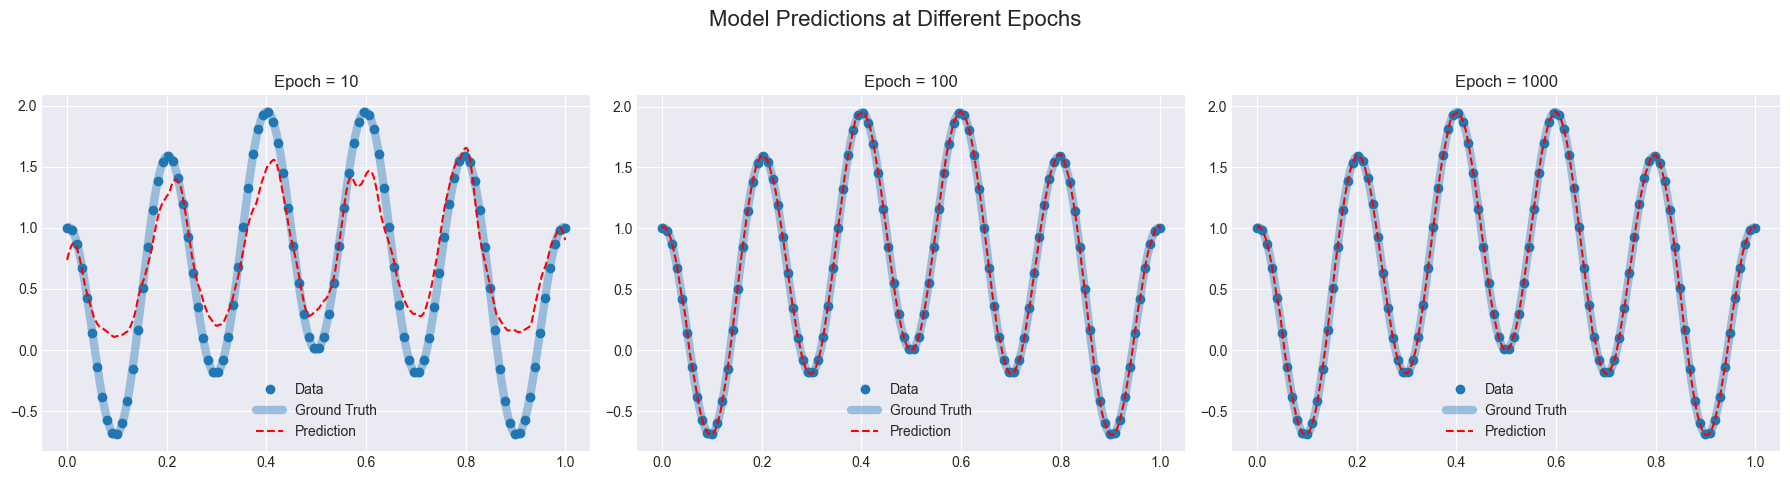

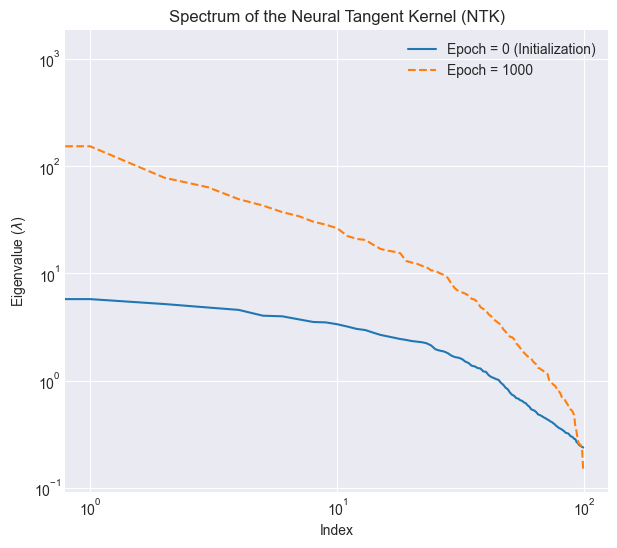

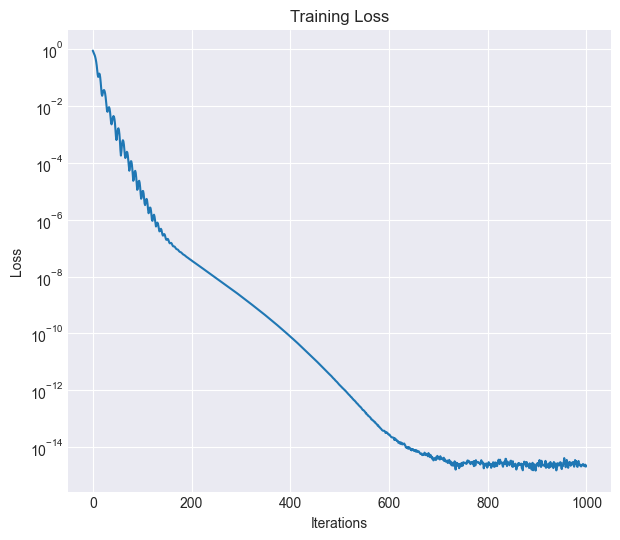

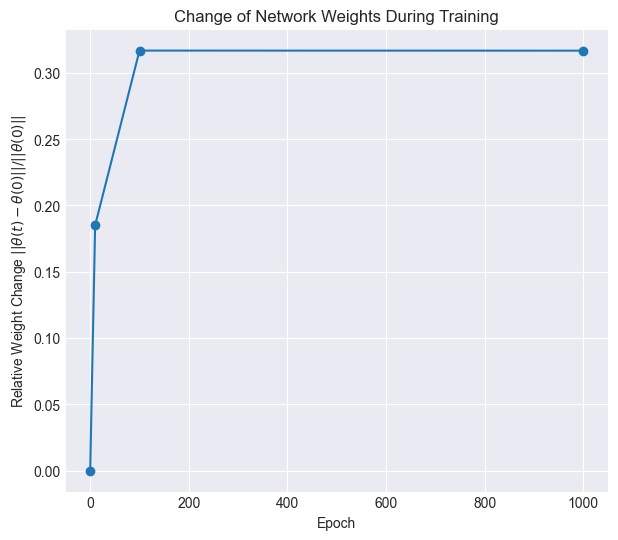

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd.functional import jacobian

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- 1. Define Target Function and Data ---
def u(x, a=10):
    """The target function f(x) = sin(pi*x) + cos(pi*a*x)"""
    return np.sin(np.pi * x) + np.cos(np.pi * a * x)

# Define computational domain and data points
N_u = 100
x_train_np = np.linspace(0, 1, N_u)[:, None]
y_train_np = u(x_train_np)

# Test data for smooth plotting
# CORRECTED: Renamed 'nn' to 'n_test' to avoid conflict with torch.nn
n_test = 1000
x_test_np = np.linspace(0, 1, n_test)[:, None]
y_test_np = u(x_test_np)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train_np).float()
y_train = torch.from_numpy(y_train_np).float()
x_test = torch.from_numpy(x_test_np).float()
y_test = torch.from_numpy(y_test_np).float()


# --- 2. Fourier Feature Mapping and Network ---
class FourierFeatureMapping(nn.Module):
    def __init__(self, input_dim, mapping_size, scale=10.0):
        super().__init__()
        self.B = nn.Parameter(torch.randn((input_dim, mapping_size)) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = (2 * np.pi * x) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Net(nn.Module):
    def __init__(self, input_features, layers):
        super().__init__()
        net_layers = []
        prev_dim = input_features
        for hidden_dim in layers[:-1]:
            net_layers.append(nn.Linear(prev_dim, hidden_dim))
            net_layers.append(nn.ReLU())
            prev_dim = hidden_dim
        net_layers.append(nn.Linear(prev_dim, layers[-1]))
        self.model = nn.Sequential(*net_layers)

    def forward(self, x):
        return self.model(x)

# --- 3. NTK and Training Setup ---
# Hyperparameters from the TF script
layers = [100, 100, 100, 1]
sigma = 10.0
mapping_size = 256 # A common choice, consistent with the paper
lr = 1e-3 # A standard learning rate for Adam

# Initialize models
fourier_mapper = FourierFeatureMapping(1, mapping_size, scale=sigma)
network = Net(mapping_size * 2, layers)

# Map inputs once
x_train_mapped = fourier_mapper(x_train)
x_test_mapped = fourier_mapper(x_test)

# Optimizer and Loss
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
criterion = nn.MSELoss()

# --- Function to compute the NTK ---
def get_ntk(x_mapped):
    """Computes the Neural Tangent Kernel."""
    network.zero_grad()
    outputs = network(x_mapped)
    
    # We need the Jacobian of the output with respect to the parameters for each input sample
    # This is a more direct way to compute the NTK in recent PyTorch versions
    
    def fnet_single(params, x_single):
        # Helper function to compute output for a single input sample given parameters
        return torch.func.functional_call(network, params, (x_single,))

    # Use torch.func.jacrev to get the jacobian for each sample
    jacobians = torch.vmap(torch.func.jacrev(fnet_single), in_dims=(None, 0))(dict(network.named_parameters()), x_mapped)
    
    # The jacobians are in a dictionary, flatten and concatenate them
    jacobians = torch.cat([j.flatten(1) for j in jacobians.values()], dim=1) # Shape: (N, num_total_params)
    
    # Compute the kernel: K = J @ J.T
    ntk = jacobians @ jacobians.T
    return ntk.detach().cpu().numpy()


# --- 4. Training Loop ---
epochs_to_run = [10, 90, 900] # Cumulative epochs: 10, 100, 1000
total_epochs = sum(epochs_to_run)
current_epoch = 0

# Lists to store data for plotting
history = {
    'loss': [],
    'predictions': {},
    'weights': {},
    'ntk': {}
}

print("Starting training and NTK calculation...")
for i, num_epochs in enumerate(epochs_to_run):
    # Store initial state before any training
    if i == 0:
        with torch.no_grad():
            history['weights'][0] = [p.clone() for p in network.parameters()]
            history['ntk'][0] = get_ntk(x_train_mapped)

    # Train for the specified number of epochs
    for epoch in range(num_epochs):
        current_epoch += 1
        network.train()
        optimizer.zero_grad()
        predictions = network(x_train_mapped)
        loss = criterion(predictions, y_train)
        loss.backward()
        optimizer.step()
        history['loss'].append(loss.item())

    # Log data after this training segment
    log_epoch = current_epoch
    print(f"Logging data at epoch: {log_epoch}")
    network.eval()
    with torch.no_grad():
        history['predictions'][log_epoch] = network(x_test_mapped).cpu().numpy()
        history['weights'][log_epoch] = [p.clone() for p in network.parameters()]
        history['ntk'][log_epoch] = get_ntk(x_train_mapped)


print("Training finished.")

# --- 5. Post-Processing and Analysis ---

# Eigenvalue analysis of NTK
lambda_K_log = {}
for epoch, K in history['ntk'].items():
    lambda_K, _ = np.linalg.eig(K)
    lambda_K_log[epoch] = np.sort(np.real(lambda_K))[::-1]

# Weight change analysis
def compute_norm(params):
    return torch.sqrt(sum(torch.sum(p**2) for p in params))

initial_norm = compute_norm(history['weights'][0])
weight_change_list = []
epochs_for_change = sorted(history['weights'].keys())

for epoch in epochs_for_change:
    diff_params = [p_curr - p_init for p_curr, p_init in zip(history['weights'][epoch], history['weights'][0])]
    diff_norm = compute_norm(diff_params)
    weight_change_list.append((diff_norm / initial_norm).item())


# --- 6. Plotting ---
print("Generating plots...")
plt.style.use('seaborn-v0_8-darkgrid')

# Plot 1: Model predictions at different epochs
fig1, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_epochs = sorted(history['predictions'].keys())
for i, epoch in enumerate(plot_epochs):
    ax = axes[i]
    ax.plot(x_train_np, y_train_np, 'o', label='Data')
    ax.plot(x_test_np, y_test_np, color='C0', alpha=0.4, linewidth=6, label='Ground Truth')
    ax.plot(x_test_np, history['predictions'][epoch], 'r--', label='Prediction')
    ax.set_title(f'Epoch = {epoch}')
    ax.legend()
fig1.suptitle('Model Predictions at Different Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Plot 2: Eigenvalues of the NTK
fig2, ax = plt.subplots(figsize=(7, 6))
ax.loglog(lambda_K_log[0], label='Epoch = 0 (Initialization)')
ax.loglog(lambda_K_log[total_epochs], '--', label=f'Epoch = {total_epochs}')
ax.set_xlabel('Index')
ax.set_ylabel(r'Eigenvalue ($\lambda$)')
ax.set_title('Spectrum of the Neural Tangent Kernel (NTK)')
ax.legend()
plt.show()


# Plot 3: Loss Curve
fig3, ax = plt.subplots(figsize=(7, 6))
ax.semilogy(history['loss'])
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
plt.show()

# Plot 4: Change of Weights
fig4, ax = plt.subplots(figsize=(7, 6))
ax.plot(epochs_for_change, weight_change_list, '-o')
ax.set_xlabel('Epoch')
ax.set_ylabel(r'Relative Weight Change $||\theta(t) - \theta(0)||/||\theta(0)||$')
ax.set_title('Change of Network Weights During Training')
plt.show()

Using device: cpu
Starting training...
Epoch: 100/40000 | Loss_BC: 4.77e+01 | Loss_Res: 3.09e+06 | L2 Error: 7.12e+00
--- Saving prediction at epoch 100 ---
Epoch: 200/40000 | Loss_BC: 6.33e+01 | Loss_Res: 3.28e+06 | L2 Error: 6.93e+00
Epoch: 300/40000 | Loss_BC: 7.44e+01 | Loss_Res: 2.89e+06 | L2 Error: 8.51e+00
Epoch: 400/40000 | Loss_BC: 3.64e+01 | Loss_Res: 3.04e+06 | L2 Error: 9.12e+00
Epoch: 500/40000 | Loss_BC: 4.31e+01 | Loss_Res: 2.81e+06 | L2 Error: 6.92e+00
Epoch: 600/40000 | Loss_BC: 7.90e+01 | Loss_Res: 2.80e+06 | L2 Error: 1.07e+01
Epoch: 700/40000 | Loss_BC: 1.11e+02 | Loss_Res: 2.67e+06 | L2 Error: 1.51e+01
Epoch: 800/40000 | Loss_BC: 1.00e+02 | Loss_Res: 2.78e+06 | L2 Error: 1.42e+01
Epoch: 900/40000 | Loss_BC: 8.55e+01 | Loss_Res: 3.01e+06 | L2 Error: 1.36e+01
Epoch: 1000/40000 | Loss_BC: 1.00e+02 | Loss_Res: 2.63e+06 | L2 Error: 1.48e+01
--- Saving prediction at epoch 1000 ---
Epoch: 1100/40000 | Loss_BC: 1.15e+02 | Loss_Res: 3.14e+06 | L2 Error: 1.56e+01
Epoch: 1200

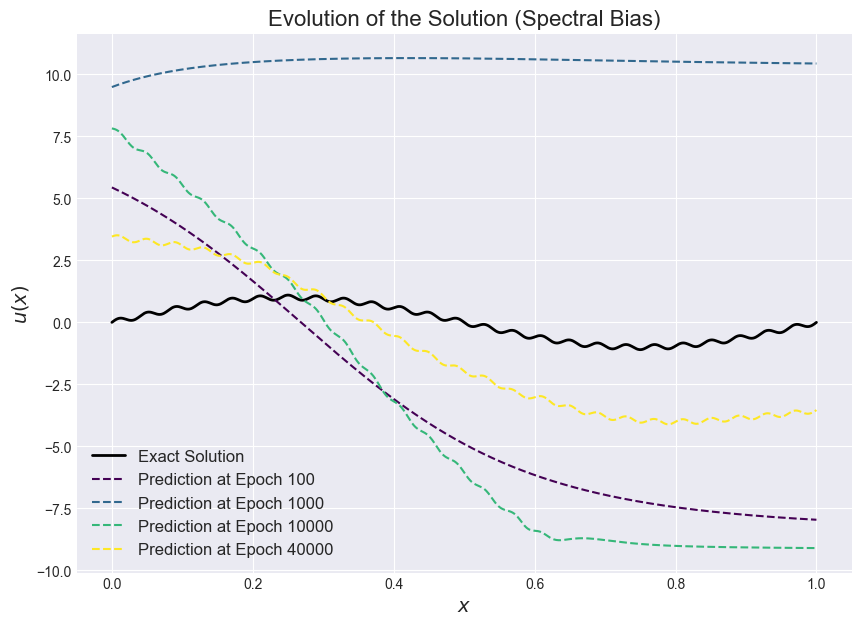

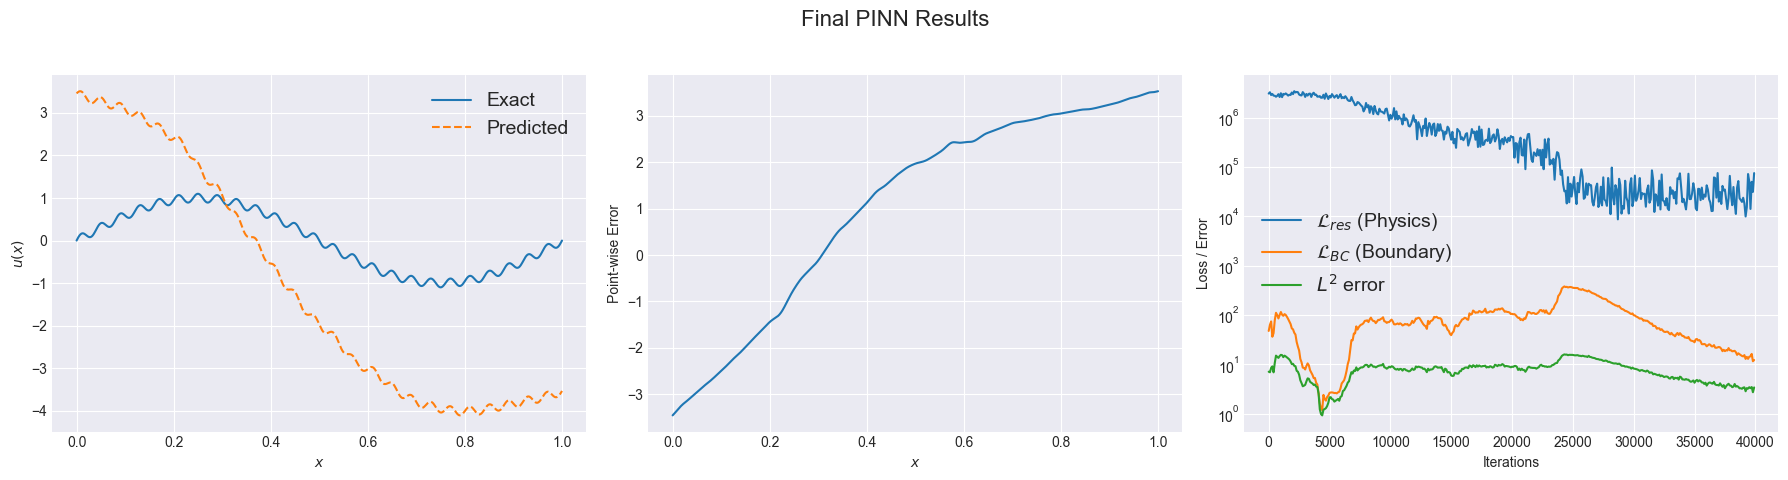

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Problem Definition ---
# Hyper-parameters for the solution
a = 2
b = 50

# Exact solution u(x)
def exact_u(x):
    return np.sin(np.pi * a * x) + 0.1 * np.sin(np.pi * b * x)

# Forcing term f(x) = u_xx(x)
def forcing_f(x):
    return -((np.pi * a)**2 * np.sin(np.pi * a * x) + 0.1 * (np.pi * b)**2 * np.sin(np.pi * b * x))

# --- 2. Neural Network Model ---
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        # Using Tanh activation function as is common in PINNs
        self.model = nn.Sequential()
        for i in range(len(layers) - 2):
            self.model.add_module(f"linear_{i}", nn.Linear(layers[i], layers[i+1]))
            self.model.add_module(f"tanh_{i}", nn.Tanh())
        self.model.add_module(f"linear_final", nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        return self.model(x)

# --- 3. The PINN Class ---
class PINN:
    def __init__(self, layers):
        self.net = Net(layers).to(device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        
        # History for plotting
        self.loss_bcs_log = []
        self.loss_res_log = []
        self.l2_error_log = []
        self.evolution_preds = {} # To store predictions at different epochs

    def get_physics_residual(self, x):
        """Computes the residual of the PDE: u_xx - f(x)"""
        x.requires_grad_(True)
        u_pred = self.net(x)
        
        # First derivative: du/dx
        u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
        
        # Second derivative: d^2u/dx^2
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        
        # Get the forcing term f(x)
        f_val = torch.from_numpy(forcing_f(x.detach().cpu().numpy())).float().to(device)
        
        return u_xx - f_val

    def train(self, n_iter, batch_size, evolution_epochs):
        print("Starting training...")
        for epoch in range(1, n_iter + 1):
            self.optimizer.zero_grad()
            
            # --- Boundary Loss ---
            # Get the boundary points x=0 and x=1
            x_bc = torch.tensor([[0.0], [1.0]], device=device)
            y_bc_true = torch.from_numpy(exact_u(x_bc.cpu().numpy())).float().to(device)
            y_bc_pred = self.net(x_bc)
            loss_bc = nn.MSELoss()(y_bc_pred, y_bc_true)
            
            # --- Residual Loss ---
            # Get random collocation points inside the domain (0, 1)
            x_collocation = torch.rand(batch_size, 1, device=device)
            residual = self.get_physics_residual(x_collocation)
            # The target for the residual is 0
            loss_res = nn.MSELoss()(residual, torch.zeros_like(residual))
            
            # --- Total Loss ---
            total_loss = loss_bc + loss_res
            total_loss.backward()
            self.optimizer.step()
            
            # --- Logging ---
            if epoch % 100 == 0:
                self.loss_bcs_log.append(loss_bc.item())
                self.loss_res_log.append(loss_res.item())
                
                # Calculate and log L2 error
                l2_err = self.calculate_l2_error()
                self.l2_error_log.append(l2_err)
                
                print(f"Epoch: {epoch}/{n_iter} | Loss_BC: {loss_bc.item():.2e} | Loss_Res: {loss_res.item():.2e} | L2 Error: {l2_err:.2e}")

            # --- Save for Evolution Plot ---
            if epoch in evolution_epochs:
                print(f"--- Saving prediction at epoch {epoch} ---")
                self.evolution_preds[epoch] = self.predict(x_test_tensor).cpu().numpy()

    def predict(self, x):
        self.net.eval()
        with torch.no_grad():
            y_pred = self.net(x)
        self.net.train()
        return y_pred

    def calculate_l2_error(self):
        u_pred = self.predict(x_test_tensor).cpu().numpy()
        error = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
        return error

# --- 4. Main Execution ---
if __name__ == '__main__':
    # Model and training parameters
    layers = [1, 100, 100, 100, 1] # Input: x (1D), Output: u (1D)
    n_iterations = 40000
    n_batch_size = 128
    
    # Epochs at which to save the solution for the evolution plot
    evolution_epochs = [100, 1000, 10000, 40000]

    # Create test data for plotting and error calculation
    x_test = np.linspace(0, 1, 1000)[:, None]
    u_star = exact_u(x_test)
    x_test_tensor = torch.from_numpy(x_test).float().to(device)

    # Initialize and train the PINN
    pinn = PINN(layers)
    pinn.train(n_iterations, n_batch_size, evolution_epochs)

    # --- 5. Plotting ---
    print("Generating plots...")
    plt.style.use('seaborn-v0_8-darkgrid')

    # --- PLOT 1: Solution Evolution (Spectral Bias) ---
    fig1 = plt.figure(figsize=(10, 7))
    plt.plot(x_test, u_star, 'k-', label='Exact Solution', linewidth=2)
    colors = plt.cm.viridis(np.linspace(0, 1, len(evolution_epochs)))
    for i, epoch in enumerate(evolution_epochs):
        plt.plot(x_test, pinn.evolution_preds[epoch], '--', color=colors[i], label=f'Prediction at Epoch {epoch}')
    plt.title('Evolution of the Solution (Spectral Bias)', fontsize=16)
    plt.xlabel('$x$', fontsize=14)
    plt.ylabel('$u(x)$', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

    # --- PLOT 2: Final Results (as in the TF script) ---
    u_pred_final = pinn.predict(x_test_tensor).cpu().numpy()
    
    fig2 = plt.figure(figsize=(18, 5))
    # Subplot 1: Exact vs. Predicted
    plt.subplot(1, 3, 1)
    plt.plot(x_test, u_star, label='Exact')
    plt.plot(x_test, u_pred_final, '--', label='Predicted')
    plt.xlabel('$x$')
    plt.ylabel('$u(x)$')
    plt.legend(fontsize=14)
    
    # Subplot 2: Point-wise Error
    plt.subplot(1, 3, 2)
    plt.plot(x_test, u_star - u_pred_final, label='Error')
    plt.xlabel('$x$')
    plt.ylabel('Point-wise Error')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    
    # Subplot 3: Loss History
    plt.subplot(1, 3, 3)
    iters = 100 * np.arange(len(pinn.loss_res_log))
    plt.plot(iters, pinn.loss_res_log, label='$\mathcal{L}_{res}$ (Physics)')
    plt.plot(iters, pinn.loss_bcs_log, label='$\mathcal{L}_{BC}$ (Boundary)')
    plt.plot(iters, pinn.l2_error_log, label=r'$L^2$ error')
    plt.yscale('log')
    plt.xlabel('Iterations')
    plt.ylabel('Loss / Error')
    plt.legend(fontsize=14)
    
    fig2.suptitle('Final PINN Results', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()